# OMNIFIT: Elias 29

The code below shows one example of how to fit the full 5-28 micron spectrum of Elias 29 (or only some selected bands) with empirically acquired spectra, export the raw fit results and plot them.

The Elias 29 spectrum originates from a file which consists of two columns of data. 
The first column contains the wavelength and the second column contains the optical depth. 
The empirical spectra being fitted to the observational spectrum, by contrast, are files containing sets of data describing the complex refractive index of the selected ice species. In particular, the first column of each empirical data file contains the wavelength of the spectrum (in microns), and the second and third columns list the real and imaginary parts of the complex refractive index. 

The full documentation of OMNIFIT can be found here: https://ricemunk.github.io/omnifit/doc/overview.html and http://oro.open.ac.uk/61309/

© Copyright 2022, Giulia Perotti

# Import the various components needed for the full fit

In [1]:
import astropy.io.ascii as asciitable
from astropy.io import ascii
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import numpy as np
from omnifit.spectrum import AbsorptionSpectrum,CDESpectrum
from omnifit.utils import unit_od
import astropy.units as u
from omnifit.fitter import Fitter
from lmfit import Parameters    
import lxml
import csv
%matplotlib notebook

Read the input data from the files which contain i) the spectrum of Elias 29 and ii) the complex refractive index spectra.

In [2]:
obs_wl,obs_od = np.loadtxt('specs/OD_EL29_silicate_subtracted.dat', dtype=float, usecols=(0,1)).T                                         
lab_wl1,lab_n1,lab_k1= np.loadtxt('nk/h2o_Rocha.txt', skiprows=27, dtype=float, usecols=(0,1,2)).T 
lab_wl2,lab_n2,lab_k2= np.loadtxt('nk/co2-a-Gerakines2020.txt', skiprows=14, dtype=float, usecols=(0,1,2)).T 
#lab_wl3,lab_n3,lab_k3= np.loadtxt('nk/ch4-a-Gerakines2020.txt', skiprows=16, dtype=float,usecols=(0,1,2)).T                   
#lab_wl4,lab_n4,lab_k4= np.loadtxt('nk/co-a-Palumbo2006.txt', skiprows=21, dtype=float, usecols=(0,1,2)).T                 
#lab_wl5,lab_n5,lab_k5= np.loadtxt('nk/ch3oh-a-Gerakines2020.txt', skiprows=14, dtype=float, usecols=(0,1,2)).T 
#lab_wl6,lab_n6,lab_k6= np.loadtxt('nk/nh3_Roser_2021.txt', skiprows=15, dtype=float, usecols=(1,2,3)).T 

Convert the first column of the complex refractive index data from wavelenghts to reciprocal wavenumbers.

In [3]:
lab_wn1=1e4/lab_wl1
lab_wn2=1e4/lab_wl2
#lab_wn3=1e4/lab_wl3
#lab_wn4=1e4/lab_wl4
#lab_wn5=1e4/lab_wl5
#lab_wn6=1e4/lab_wl6

Initialise the target spectrum as an absorption spectrum and the CDE-corrected spectra using the data read in the cells above. 

In [4]:
obs_spec = AbsorptionSpectrum(obs_wl*u.micron,obs_od*unit_od,specname='Observed data')                          
lab_spec1= CDESpectrum(lab_wn1,lab_n1+lab_k1*1j,specname='Laboratory data')                         
lab_spec2= CDESpectrum(lab_wn2,lab_n2+lab_k2*1j,specname='Laboratory data')
#lab_spec3= CDESpectrum(lab_wn3,lab_n3+lab_k3*1j,specname='Laboratory data')
#lab_spec4= CDESpectrum(lab_wn4,lab_n4+lab_k4*1j,specname='Laboratory data')
#lab_spec5= CDESpectrum(lab_wn5,lab_n5+lab_k5*1j,specname='Laboratory data')
#lab_spec6= CDESpectrum(lab_wn6,lab_n6+lab_k6*1j,specname='Laboratory data')

/Users/willrocha/Downloads/omnifit_ifw/omnifit/spectrum/spectrum.py:722: RuntimeWarning: Input wn is not in kayser units. Converting...
  warnings.warn(
/Users/willrocha/Downloads/omnifit_ifw/omnifit/utils/utils.py:211: RuntimeWarning: invalid value encountered in log10
  cabs = freq*(2.0*m.imag/(m.imag-1))*np.log10(m.imag)


Interpolate the data in the CDE-corrected spectra to match the spectral resolution of the spectrum of Elias 29. Once this is done, the fitter is initialised.

In [5]:
interp_lab1= lab_spec1.interpolate(obs_spec,clone=True)                          
interp_lab2= lab_spec2.interpolate(obs_spec,clone=True)                                          
#interp_lab3= lab_spec3.interpolate(obs_spec,clone=True)
#interp_lab4= lab_spec4.interpolate(obs_spec,clone=True)
#interp_lab5= lab_spec5.interpolate(obs_spec,clone=True)
#interp_lab6= lab_spec6.interpolate(obs_spec,clone=True) 

fitter= Fitter.fromspectrum(obs_spec,dy=3.0,modelname='Elias_29',fitrange=[[620,900]]) 

Note: multiple fitting range (in reciprocal wavenumbers) can be specified, if desired, when initializing the fitter. e.g. fitter= Fitter.fromspectrum(obs_spec,dy=3.0,modelname='Elias_29', fitrange=[[2777,2940],[3222,3267],[3400,3500]]). This argument is inserted if only specific regions of the observed spectrum wants to be fitted. 

# Prepare the fitting parameters

Prepare the fitting parameters for an empirical data, containing only an initial guess (0.3) for the best-fit multiplier (k). These parameters and the data to be fitted are then given to the fitter.

In [6]:
lab_par1=Parameters()
lab_par2=Parameters()
#lab_par3=Parameters()
#lab_par4=Parameters()

lab_par1.add('mul',value=0.3,min=0.0)                                                             
lab_par2.add('mul',value=0.3,min=0.0)
#lab_par3.add('mul',value=0.3,min=0.0)   
#lab_par4.add('mul',value=0.3,min=0.0) 

fitter.add_empirical(interp_lab1,lab_par1,funcname='H2O', color='blue')  
fitter.add_empirical(interp_lab2,lab_par2,funcname='CO2',color='cyan')
#fitter.add_empirical(interp_lab3,lab_par3,funcname='CH4',color='dodgerblue')
#fitter.add_empirical(interp_lab4,lab_par4,funcname='CO',color='orange')


# Perform the fitting

In [7]:
fitter.perform_fit()
fitter.fitresults_tofile('fitting_results/fitres_elias_29') 

After it is done, two output files are produced, fitres_elias_29.csv and fitres_elias_29.xml, which contain all the information on the fit results. 

# Plot the fit results

Produce a plot of the fit results in the file omnifit_elias29.pdf.

<IPython.core.display.Javascript object>


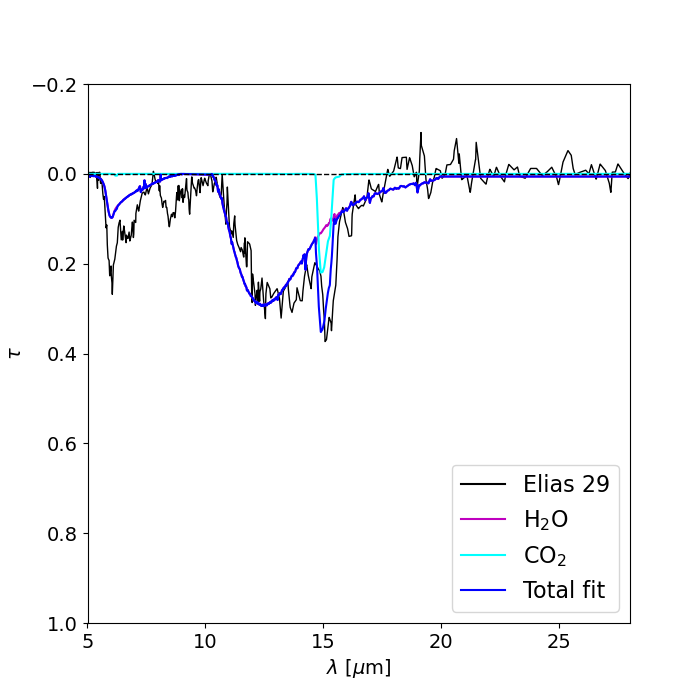

In [8]:
fig=plt.figure(figsize=(7,7))

t= ascii.read('fitting_results/fitres_elias_29.csv')  
x = 1e4/(t['col1'])
y = t['col2']
tot = t['col3']
lab1 = t['col4']
lab2 = t['col5']
#lab3 = t['col6']
#lab4 = t['col7']

plt.plot(x,y,color='k', lw=1, label='Elias 29')
plt.plot(x,lab1,color='m', lw=1.5, label='')               # H2O 
plt.plot(x,lab2,color='cyan', lw='1.5', label='')          # CO2
#plt.plot(x,lab3,color='dodgerblue', lw='1.5', label='')   # CH4  
#plt.plot(x,lab4,color='orange', lw='1.5', label='')       # CO
plt.plot(x,tot,color='b', lw='1.5', label='')              # Total fit

plt.axhline(y=0., xmin=0, xmax=1, color='k',ls='dashed',lw=1.)
plt.ylim(1.0,-0.2)
#plt.ylim(2.5,-0.2)
plt.xlim(5,28)
#plt.xlim(2.5,30)
plt.ylabel(r'$\tau$', fontsize='14')
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize='14')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
custom_lines = [Line2D([0], [0], color='k', lw=1.5),
Line2D([0], [0], color='m', lw=1.5),
#Line2D([0], [0], color='dodgerblue', lw=1.5),
#Line2D([0], [0], color='orange', lw=1.5),
Line2D([0], [0], color='cyan', lw=1.5),
Line2D([0], [0], color='b', lw=1.5)] 
plt.legend(custom_lines, ['Elias 29','H$_2$O','CO$_2$', 'Total fit'], loc='lower right', prop={'size': 16})

plt.savefig('figures/omnifit_elias29.pdf')